#### 拓扑排序

编译器又该如何通过源文件两两之间的局部依赖关系，确定一个全局的编译顺序

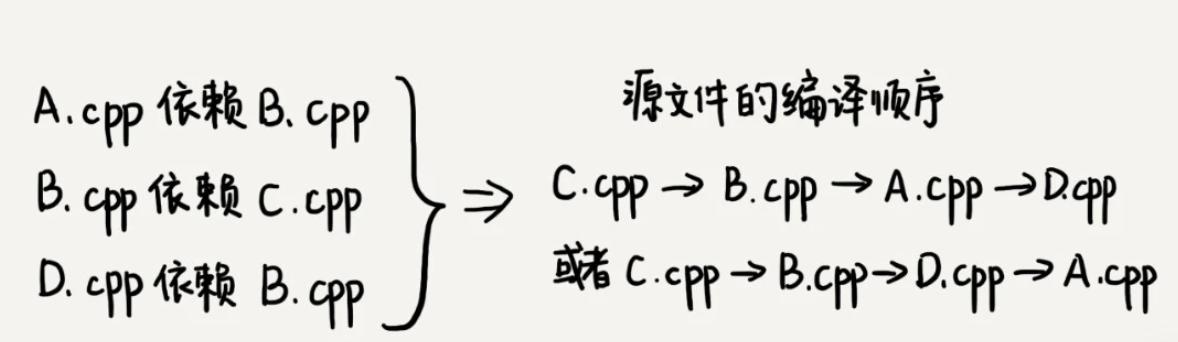



#### 算法解析

* 拓扑排序的序列并不是唯一的
* 有向无环图

~~~

public class Graph {
  private int v; // 顶点的个数
  private LinkedList<Integer> adj[]; // 邻接表

  public Graph(int v) {
    this.v = v;
    adj = new LinkedList[v];
    for (int i=0; i<v; ++i) {
      adj[i] = new LinkedList<>();
    }
  }

  public void addEdge(int s, int t) { // s先于t，边s->t
    adj[s].add(t);
  }
}

~~~

##### Kahn 算法

实际上是贪心算法
* 从图中，找出入度为 0 的顶点，将其输入到拓扑排序的结果序列中（对应代码中的就是把它打印出来）
* 把这个顶点从图中删除（也就是把这个顶点可达到的顶点的入度-1）
* 循环执行上面的过程，知道所有的顶点都被输出
* 最后输出的序列，就是满足局部依赖关系的拓扑序列

时间复杂度：
* 每个顶点被访问一次，每个边被访问一次
* O(V+E)
  
~~~

public void topoSortByKahn() {
  int[] inDegree = new int[v]; // 统计每个顶点的入度
  for (int i = 0; i < v; ++i) {
    for (int j = 0; j < adj[i].size(); ++j) {
      int w = adj[i].get(j); // i->w
      inDegree[w]++;
    }
  }
  LinkedList<Integer> queue = new LinkedList<>();
  for (int i = 0; i < v; ++i) {
    if (inDegree[i] == 0) queue.add(i);
  }
  while (!queue.isEmpty()) {
    int i = queue.remove();
    System.out.print("->" + i);
    for (int j = 0; j < adj[i].size(); ++j) {
      int k = adj[i].get(j);
      inDegree[k]--;
      if (inDegree[k] == 0) queue.add(k);
    }
  }
}

~~~

##### DFS 算法

* 实际上，拓扑排序也可以用深度优先搜索来实现
* 更加确切的说法应该是深度优先遍历，遍历图中的所有顶点，而非只是搜索一个顶点到另一个顶点的路径

算法关键部分：
1. 通过领接表构造逆邻接表。
   1. 邻接表中，边 s->t 表示 s 先于 t 执行，也就是 t 要依赖 s。
   2. 在逆邻接表中，边 s->t 表示 s 依赖于 t，s 后于 t 执行
2. 递归处理每个顶点
   1. 对于顶点 vertex 来说，先输出它可达的所有顶点，也就是说，先把它依赖的所有的顶点输出了，然后再输出自己。

时间复杂度：
* 每个顶点被访问两次，每条边被访问一次
* O(V+E)

~~~

public void topoSortByDFS() {
  // 先构建逆邻接表，边s->t表示，s依赖于t，t先于s
  LinkedList<Integer> inverseAdj[] = new LinkedList[v];
  for (int i = 0; i < v; ++i) { // 申请空间
    inverseAdj[i] = new LinkedList<>();
  }
  for (int i = 0; i < v; ++i) { // 通过邻接表生成逆邻接表
    for (int j = 0; j < adj[i].size(); ++j) {
      int w = adj[i].get(j); // i->w
      inverseAdj[w].add(i); // w->i
    }
  }
  boolean[] visited = new boolean[v];
  for (int i = 0; i < v; ++i) { // 深度优先遍历图
    if (visited[i] == false) {
      visited[i] = true;
      dfs(i, inverseAdj, visited);
    }
  }
}

private void dfs(
    int vertex, LinkedList<Integer> inverseAdj[], boolean[] visited) {
  for (int i = 0; i < inverseAdj[vertex].size(); ++i) {
    int w = inverseAdj[vertex].get(i);
    if (visited[w] == true) continue;
    visited[w] = true;
    dfs(w, inverseAdj, visited);
  } // 先把vertex这个顶点可达的所有顶点都打印出来之后，再打印它自己
  System.out.print("->" + vertex);
}

~~~

##### 检测图中环的存在

1. 对于 Kahn 算法涞水，如果最后输出出来的顶点个数，少于图中的顶点个数，图中还存在入度不是 0 的顶点，那就说明，图中存在环

在查找最终推荐人的时候，可能会因为脏数据，造成存在循环推荐，比如，用户 A 推荐了用户 B，用户 B 推荐了用户 C，用户 C 又推荐了用户 A。

实际上，这就是环的检测问题。因为每次都只是查找一个用户的最终推荐人，所以，并不需要动用复杂的拓扑排序算法，而只需要记录已经访问过的用户 ID，当用户 ID 第二次被访问的时候，就说明存在环，也就说明存在脏数据。


~~~

HashSet<Integer> hashTable = new HashSet<>(); // 保存已经访问过的actorId
long findRootReferrerId(long actorId) {
  if (hashTable.contains(actorId)) { // 存在环
    return;
  }
  hashTable.add(actorId);
  Long referrerId = 
       select referrer_id from [table] where actor_id = actorId;
  if (referrerId == null) return actorId;
  return findRootReferrerId(referrerId);
}

~~~


如果把这个问题改一下，要确认数据库中的所有用户之间的推荐关系了，有没有存在环的情况。这个问题，就需要用到拓扑排序算法了。把用户之间的推荐关系，从数据库中加载到内存中，然后构建成今天讲的这种有向图数据结构，再利用拓扑排序，就可以快速检测出是否存在环了。
